### License

Copyright 2021 Patrick Hall (jphall@gwu.edu), Melis Diken(midiken@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

DISCLAIMER: This notebook is not legal or compliance advice.

## Assignment 4

In [1]:

import h2o                                                        # h2o python library
from h2o.backend import H2OLocalServer                            # for model extraction
from h2o.estimators.random_forest import H2ORandomForestEstimator # for decision tree in model extraction
import matplotlib.pyplot as plt                                   # for plots
import numpy as np                                                # for basic array manipulation                            
import pandas as pd                                               # for dataframe manipulation
import subprocess                                                 # to run external processes for model extraction
import time                                                       # for timers
import xgboost as xgb                                             # base xgboost package for python


# enables display of images in notebook
from IPython.display import Image
from IPython.display import display

# set numpy random seed for better reproducibility
SEED = 12345 
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='2G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators  

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_25"; Java(TM) SE Runtime Environment (build 1.8.0_25-b17); Java HotSpot(TM) 64-Bit Server VM (build 25.25-b02, mixed mode)
  Starting server from /Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/h6/tg80141j4ys8tw_5g6p9b7vc0000gn/T/tmpufxxdg57
  JVM stdout: /var/folders/h6/tg80141j4ys8tw_5g6p9b7vc0000gn/T/tmpufxxdg57/h2o_melisdiken_started_from_python.out
  JVM stderr: /var/folders/h6/tg80141j4ys8tw_5g6p9b7vc0000gn/T/tmpufxxdg57/h2o_melisdiken_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,2 months and 1 day
H2O_cluster_name:,H2O_from_python_melisdiken_9h6bit
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.778 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Define utility functions

#### Utility function that trains a cross-validated decision tree

In [2]:
def get_cv_dt(x_names, y_name, train, model_id, seed_, title, valid=None):

    """ Utility function to train decision trees.
    Args:
        x_names: Names of input variables as a list.
        y_name: Name of target variable.
        train: Pandas DataFrame containing x_names and y_name on which to train
               decision tree.
        model_id: h2o model identifier.
        seed_: Random seed for improved reproducibility.
        title: Title for generated plot of tree.
        valid: Optional validation data.
    Returns:
        Model as h2o model object.
    """

    # initialize single tree model
    tree = H2ORandomForestEstimator(ntrees=1,  # use only one tree
                                    sample_rate=1,  # use all rows in that tree
                                    mtries=-2,  # use all columns in that tree's split search
                                    max_depth=4,  # shallow trees are easier to understand
                                    seed=seed_,  # set random seed for reproducibility
                                    nfolds=3,  # cross-validation for stability and ...
                                    # only way to get metrics for 1 tree in h2o
                                    model_id=model_id)  # gives MOJO artifact a recognizable name

    # train single tree model
    if valid is not None:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train), validation_frame=h2o.H2OFrame(valid))
    else:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train))

    # persist MOJO (compiled Java representation of trained model)
    # from which to generate plot of tree
    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)

    # generate graphviz file and then PNG
    get_gv(title, model_id, mojo_path)
    get_png(model_id)

    return tree

#### Utility function that converts h2o MOJO into graphviz file

In [3]:
def get_gv(title, model_id, mojo_path):
    
    """ Utility function to generate graphviz dot file from h2o MOJO using
        a subprocess.
        
    Args:
        title: Title for displayed decision tree.
        model_id: h2o model identifier.
        mojo_path: Path to saved model MOJO (Java scoring artifact);
                   generated by train_cv_dt function above.
    """

    # locate h2o jar
    hs = H2OLocalServer()
    h2o_jar_path = hs._find_jar()
    print('Discovered H2O jar path:\n', h2o_jar_path)

    # construct command line call to generate graphviz version of
    # tree, see for more information:
    # http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
    gv_file_name = model_id + '.gv'
    gv_args = str('-cp ' + h2o_jar_path +
                  ' hex.genmodel.tools.PrintMojo --tree 0 -i "'
                  + mojo_path + '" -o').split()
    gv_args.insert(0, 'java')
    gv_args.append(gv_file_name)
    if title is not None:
        gv_args = gv_args + ['--title', '"' + str(title) + '"']

    # call constructed command
    print()
    print('Calling external process ...')
    print(' '.join(gv_args))
    # if the line below is failing for you, try instead:
    # _ = subprocess.call(gv_args, shell=True)
    _ = subprocess.call(gv_args)

#### Utility function that converts graphviz file into PNG

In [4]:
def get_png(model_id):

    """ Utility function to generate PNGs from .dots using a subprocess.
    Arg:
        model_id: h2o model identifier.
    """

    gv_file_name = model_id + '.gv'

    # construct call to generate PNG from
    # graphviz representation of the tree
    png_file_name = model_id + '.png'
    png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
    png_args = png_args.split()

    # call
    print('Calling external process ...')
    print(' '.join(png_args))
    # if the line below is failing for you, try instead:
    # _ = subprocess.call(png_args, shell=True)
    _ = subprocess.call(png_args)

#### Start global timer

In [5]:
tic = time.time()

#### Import data

In [6]:
data = pd.read_csv('hmda_train_preprocessed.csv')

#### Assign basic modeling roles

In [7]:
y_name = 'high_priced'

### Fit interpretable models

#### Split data into train and validation partitions

In [8]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Monotonic XGBoost

#### Retrain most accurate model above 0.8 AIR to act as blackbox prediction API¶

In [9]:
# params dict for remediated models
rem_params = {'colsample_bytree': 0.3,
             'colsample_bylevel': 0.9,
             'eta': 0.005,
             'max_depth': 7,
             'reg_alpha': 0.05,
             'reg_lambda': 0.0005,
             'subsample': 0.7,
             'min_child_weight': 10,
             'gamma': 0.4,
             'booster': 'gbtree',
             'eval_metric': 'auc',
             'monotone_constraints': (1,),
             'nthread': 4,
             'objective': 'binary:logistic',
             'seed': 12345}

rem_x_names = ['no_intro_rate_period_std',
             'debt_to_income_ratio_missing',
             'loan_to_value_ratio_std',
             'intro_rate_period_std',
             'conforming',
             'debt_to_income_ratio_std',
             'income_std',
             'loan_amount_std',
             'term_360']

# retrain

dtrain = xgb.DMatrix(train[rem_x_names], train[y_name])
dvalid = xgb.DMatrix(valid[rem_x_names], valid[y_name])
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
ntree=1000
early_stopping_rounds=100
rem_mxgb= xgb.train(rem_params,
                    dtrain,
                    ntree,
                    early_stopping_rounds=early_stopping_rounds,
                    evals=watchlist)   
        

    

print('Remediated XGB retrained with AUC: %.4f.' % rem_mxgb.best_score)


[0]	train-auc:0.63716	eval-auc:0.64160
[1]	train-auc:0.63733	eval-auc:0.64191
[2]	train-auc:0.76864	eval-auc:0.76897
[3]	train-auc:0.76996	eval-auc:0.77085
[4]	train-auc:0.78070	eval-auc:0.77963
[5]	train-auc:0.77899	eval-auc:0.77737
[6]	train-auc:0.77310	eval-auc:0.77250
[7]	train-auc:0.77219	eval-auc:0.77174
[8]	train-auc:0.76455	eval-auc:0.76304
[9]	train-auc:0.76518	eval-auc:0.76387
[10]	train-auc:0.76545	eval-auc:0.76363
[11]	train-auc:0.78312	eval-auc:0.78103
[12]	train-auc:0.79068	eval-auc:0.78958
[13]	train-auc:0.79128	eval-auc:0.79060
[14]	train-auc:0.79123	eval-auc:0.79049
[15]	train-auc:0.79138	eval-auc:0.79084
[16]	train-auc:0.79130	eval-auc:0.79069
[17]	train-auc:0.79182	eval-auc:0.79084
[18]	train-auc:0.79154	eval-auc:0.79064
[19]	train-auc:0.79220	eval-auc:0.79133
[20]	train-auc:0.79600	eval-auc:0.79519
[21]	train-auc:0.79584	eval-auc:0.79497
[22]	train-auc:0.79577	eval-auc:0.79458
[23]	train-auc:0.79472	eval-auc:0.79339
[24]	train-auc:0.79161	eval-auc:0.78980
[25]	train

[203]	train-auc:0.80212	eval-auc:0.80113
[204]	train-auc:0.80226	eval-auc:0.80125
[205]	train-auc:0.80223	eval-auc:0.80117
[206]	train-auc:0.80247	eval-auc:0.80153
[207]	train-auc:0.80243	eval-auc:0.80145
[208]	train-auc:0.80237	eval-auc:0.80132
[209]	train-auc:0.80215	eval-auc:0.80110
[210]	train-auc:0.80202	eval-auc:0.80086
[211]	train-auc:0.80212	eval-auc:0.80094
[212]	train-auc:0.80164	eval-auc:0.80045
[213]	train-auc:0.80122	eval-auc:0.79988
[214]	train-auc:0.80099	eval-auc:0.79963
[215]	train-auc:0.80053	eval-auc:0.79918
[216]	train-auc:0.80049	eval-auc:0.79911
[217]	train-auc:0.79999	eval-auc:0.79859
[218]	train-auc:0.79959	eval-auc:0.79806
[219]	train-auc:0.79937	eval-auc:0.79776
[220]	train-auc:0.79929	eval-auc:0.79761
[221]	train-auc:0.79901	eval-auc:0.79740
[222]	train-auc:0.79900	eval-auc:0.79740
[223]	train-auc:0.79873	eval-auc:0.79715
[224]	train-auc:0.79922	eval-auc:0.79773
[225]	train-auc:0.79922	eval-auc:0.79773
[226]	train-auc:0.79941	eval-auc:0.79803
[227]	train-auc:

## Model Extraction Attack

#### Generate synthetic data for extraction attack

For an API or model to be usable by customers or others, the system documentation must contain basic information about expected input variables. Between that information, domain knowledge, and publicly available information, an attacker can make a good guess at what the input data should look like.

In [10]:
# best guess at feature distributions
schema_dict = {'term_360':                     {'p': 0.9, 'dist': 'binomial'},
               'conforming':                   {'p': 0.9, 'dist': 'binomial'},
               'debt_to_income_ratio_missing': {'p': 0.1, 'dist': 'binomial'},
               'no_intro_rate_period_std':     {'p': 0.1, 'dist': 'binomial'},
               'loan_amount_std':              {'min': -5, 'scale': 10, 'dist': 'exponential'}, 
               'intro_rate_period_std':        {'min': 0, 'scale': 2, 'dist': 'exponential'}, 
               'income_std':                   {'min': -5, 'scale': 25, 'dist': 'exponential'},
               'debt_to_income_ratio_std':     {'mean': 1, 'scale': 1, 'dist': 'normal'},
               'loan_to_value_ratio_std':     {'mean': 1, 'scale': 1, 'dist': 'normal'}}

N = 10000 # rows of simulated data

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) # init empty frame
                            
np.random.seed(SEED) # same results each time cell is run    
    
for j in list(schema_dict.keys()): # loop through features
    
    # simulate normal features
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'], 
                                           size=N)
    
    # simulate expontential features
    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'], 
                                                                        size=N)
        
    # simulate binomial features
    if schema_dict[j]['dist'] == 'binomial':
        random_frame[j] = np.random.binomial(1, schema_dict[j]['p'], N)
        
# make up for no_intro_rate_period_std scale shift
random_frame['no_intro_rate_period_std'] = -4 * random_frame['no_intro_rate_period_std'] 

#### Visualize simulated data

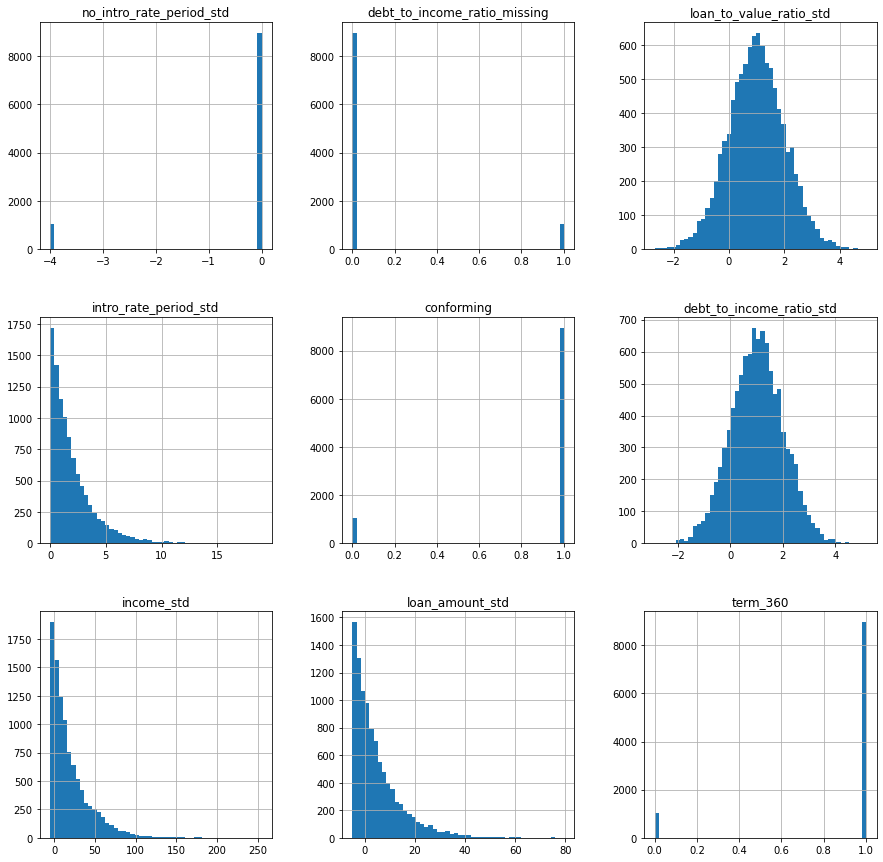

In [11]:
_ = random_frame[rem_x_names].hist(bins=50, figsize=(15, 15))

#### irst call to blackbox model for predictions on random data

In [12]:
# create a frame with remediated XGB predictions
dram = xgb.DMatrix(random_frame[rem_x_names])
blackbox_phat= pd.DataFrame(rem_mxgb.predict(dram, iteration_range=(0, rem_mxgb.best_ntree_limit)), columns=['phat']) 
blackbox_phat = pd.concat([valid.reset_index(drop=True), blackbox_phat], axis=1)

blackbox_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.241616
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.237334
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.240697
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.233898
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.243378


#### Extract a stolen decision tree model

In [13]:
stolen_dt = get_cv_dt(list(schema_dict.keys()),
                      'phat',
                      blackbox_phat,
                      'stolen_dt', 
                      SEED, 
                      'Stolen Model')


Generated MOJO path:
 /Users/melisdiken/Desktop/Summer 2022 ML /Assignment_4/stolen_dt.zip
Discovered H2O jar path:
 /Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /Users/melisdiken/opt/anaconda3/envs/myenv2/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i "/Users/melisdiken/Desktop/Summer 2022 ML /Assignment_4/stolen_dt.zip" -o stolen_dt.gv --title "Stolen Model"
Calling external process ...
dot -Tpng stolen_dt.gv -o stolen_dt.png


#### View stolen model

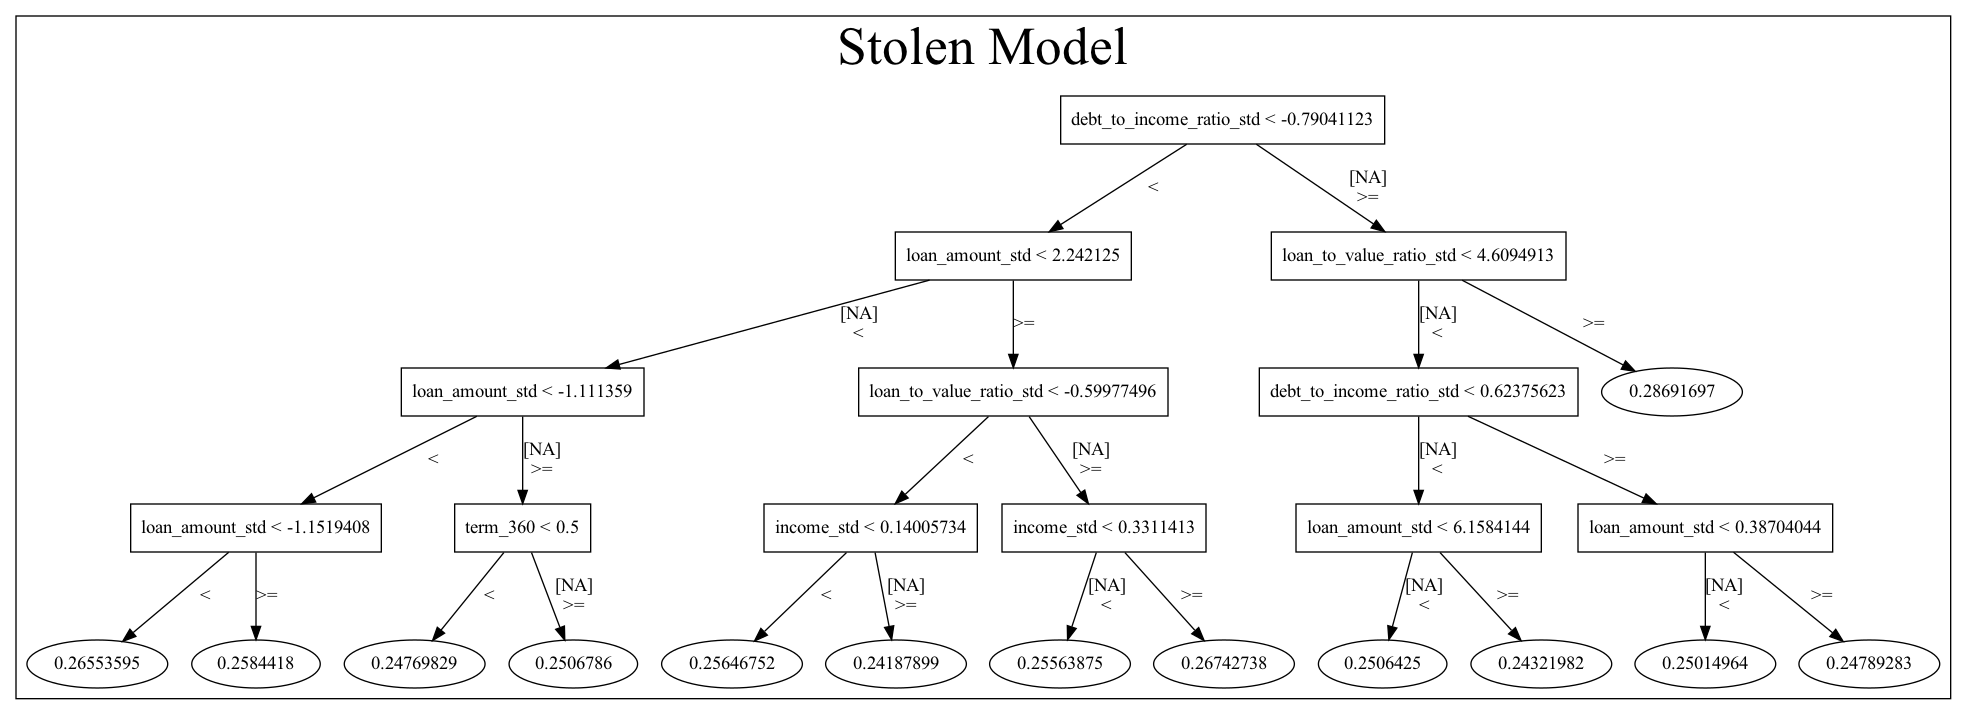

In [14]:
display(Image(('stolen_dt.png')))

#### Variable importance for stolen model

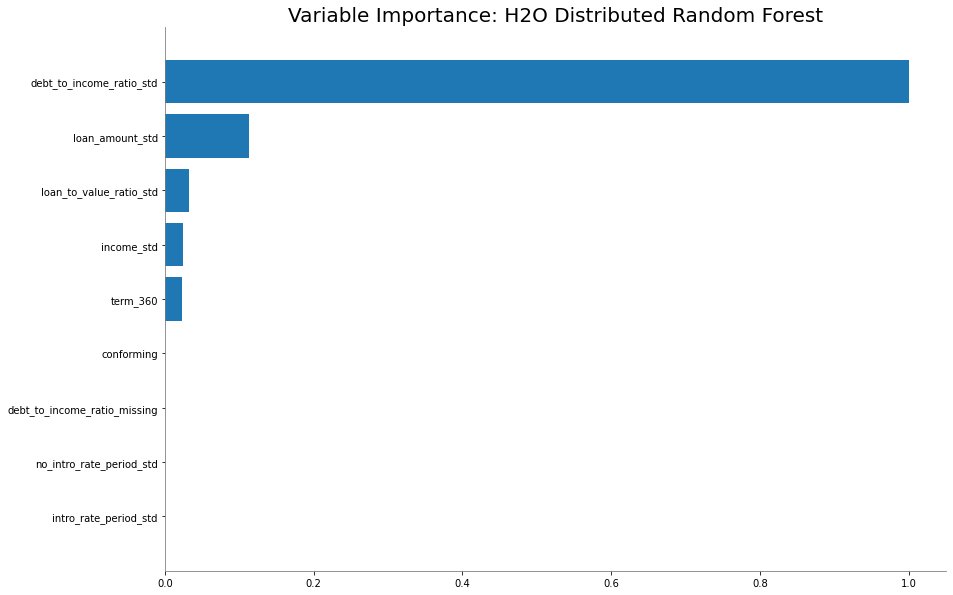

<Figure size 432x288 with 0 Axes>

In [15]:
stolen_dt.varimp_plot()

These are the most important variables in the stolen model, and likely in the real model too.

#### Assess accuracy of stolen model

In [16]:
stolen_dt.cross_validation_metrics_summary() # h2o makes cv evaluation metrics available


Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,mae,0.011052,0.000076,0.011071,0.010969,0.011116
1,mean_residual_deviance,0.000192,0.000004,0.000192,0.000188,0.000196
2,mse,0.000192,0.000004,0.000192,0.000188,0.000196
3,r2,-0.007150,0.002065,-0.008920,-0.004882,-0.007648
4,residual_deviance,0.000192,0.000004,0.000192,0.000188,0.000196
5,rmse,0.013854,0.000137,0.013841,0.013725,0.013998
6,rmsle,0.011064,0.000106,0.011059,0.010961,0.011173


### Use Stolen Model to Craft Adversarial Examples

#### Use stolen model to find seed rows for adversary searches

In [17]:
low_adversary_seed = random_frame.loc[
                                      (random_frame['loan_to_value_ratio_std'] < 4.609) & 
                                      (random_frame['debt_to_income_ratio_std'] >= 0.6238) &
                                      (random_frame['loan_amount_std'] >= 0.3870), :].mean()
print('Low adversarial example search seed row:')
print(low_adversary_seed)
print()

high_adversary_seed = random_frame.loc[(random_frame['debt_to_income_ratio_std'] < -0.79) &
                                       (random_frame['loan_amount_std'] < 2.242) & 
                                       (random_frame['loan_amount_std'] >= -1.11) & 
                                       (random_frame['term_360'] >= 0.5), :].mean()
print('High adversarial example search seed row:')
print(high_adversary_seed)

Low adversarial example search seed row:
term_360                         0.896426
conforming                       0.897991
debt_to_income_ratio_missing     0.096530
no_intro_rate_period_std        -0.399687
loan_amount_std                 10.380848
intro_rate_period_std            1.989493
income_std                      19.739497
debt_to_income_ratio_std         1.576369
loan_to_value_ratio_std          0.993202
dtype: float64

High adversarial example search seed row:
term_360                         1.000000
conforming                       0.820896
debt_to_income_ratio_missing     0.134328
no_intro_rate_period_std        -0.597015
loan_amount_std                  0.599603
intro_rate_period_std            1.885007
income_std                      20.452333
debt_to_income_ratio_std        -1.183814
loan_to_value_ratio_std          0.875570
dtype: float64


#### Perturb seed row to find low scoring adversarial examples

In [18]:
# init results frames
low_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys())) 

# quantiles over which to search 
low_quantiles = [0.01, 0.05, 0.1, 0.25, 0.5] 
high_quantiles = [0.99, 0.95, 0.9, 0.75, 0.5]

# generate potential adversarial examples across four important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['debt_to_income_ratio_std'].quantile(high_quantiles)): 
        for b in list(random_frame['loan_amount_std'].quantile(high_quantiles)):
            for c in list(random_frame['loan_to_value_ratio_std'].quantile(low_quantiles)):
                for d in list(random_frame['income_std'].quantile(low_quantiles)):
                    low_adversary_seed['debt_to_income_ratio_std'] = a
                    low_adversary_seed['loan_amount_std'] = b
                    low_adversary_seed['loan_to_value_ratio_std'] = c
                    low_adversary_seed['income_std'] = d
                    low_adversary_frame = low_adversary_frame.append(low_adversary_seed, 
                                                                     ignore_index=True, sort=False)
                    
# view potential low scoring adversarial examples
low_adversary_frame.head()

,term_360,conforming,debt_to_income_ratio_missing,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,income_std,debt_to_income_ratio_std,loan_to_value_ratio_std
0,0.896426,0.897991,0.09653,-0.399687,40.347898,1.989493,-4.734940,3.322541,-1.408547
1,0.896426,0.897991,0.09653,-0.399687,40.347898,1.989493,-3.767635,3.322541,-1.408547
2,0.896426,0.897991,0.09653,-0.399687,40.347898,1.989493,-2.348467,3.322541,-1.408547
3,0.896426,0.897991,0.09653,-0.399687,40.347898,1.989493,1.927751,3.322541,-1.408547
4,0.896426,0.897991,0.09653,-0.399687,40.347898,1.989493,12.063387,3.322541,-1.408547


#### Perturb seed row to find high scoring adversarial examples

In [19]:
# init results frames
high_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys())) 

# generate potential adversarial examples across four important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['debt_to_income_ratio_std'].quantile(low_quantiles)): 
        for b in list(random_frame['loan_amount_std'].quantile(low_quantiles)):
            for c in list(random_frame['loan_to_value_ratio_std'].quantile(high_quantiles)):
                for d in list(random_frame['income_std'].quantile(high_quantiles)):
                    high_adversary_seed['debt_to_income_ratio_std'] = a
                    high_adversary_seed['loan_amount_std'] = b
                    high_adversary_seed['loan_to_value_ratio_std'] = c
                    high_adversary_seed['income_std'] = d
                    high_adversary_frame = high_adversary_frame.append(high_adversary_seed, 
                                                                       ignore_index=True, sort=False)
                    
# view potential high scoring adversarial examples
high_adversary_frame.head()

,term_360,conforming,debt_to_income_ratio_missing,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,income_std,debt_to_income_ratio_std,loan_to_value_ratio_std
0,1.0,0.820896,0.134328,-0.597015,-4.909125,1.885007,109.784040,-1.29433,3.37921
1,1.0,0.820896,0.134328,-0.597015,-4.909125,1.885007,69.929733,-1.29433,3.37921
2,1.0,0.820896,0.134328,-0.597015,-4.909125,1.885007,54.012681,-1.29433,3.37921
3,1.0,0.820896,0.134328,-0.597015,-4.909125,1.885007,29.864155,-1.29433,3.37921
4,1.0,0.820896,0.134328,-0.597015,-4.909125,1.885007,12.063387,-1.29433,3.37921


#### Second call to blackbox API to test adversarial examples

In [20]:
# combine potential adversaries so only one call to API is needed
adversaries = pd.concat([low_adversary_frame, high_adversary_frame], axis=0)
dadver = xgb.DMatrix(adversaries[rem_x_names])

# score potential adversarial examples to understand their effect on generated predictions
blackbox_adversaries_phat= pd.DataFrame(rem_mxgb.predict(dadver, iteration_range=(0, rem_mxgb.best_ntree_limit)), columns=['phat']) 
blackbox_adversaries_phat = pd.concat([adversaries.reset_index(drop=True), blackbox_adversaries_phat], axis=1)
blackbox_adversaries_phat.sort_values(by='phat')

,term_360,conforming,debt_to_income_ratio_missing,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,income_std,debt_to_income_ratio_std,loan_to_value_ratio_std,phat
745,1.000000,0.820896,0.134328,-0.597015,1.918117,1.885007,109.784040,-1.294330,0.988326,0.237760
749,1.000000,0.820896,0.134328,-0.597015,1.918117,1.885007,12.063387,-1.294330,0.988326,0.237760
748,1.000000,0.820896,0.134328,-0.597015,1.918117,1.885007,29.864155,-1.294330,0.988326,0.237760
747,1.000000,0.820896,0.134328,-0.597015,1.918117,1.885007,54.012681,-1.294330,0.988326,0.237760
746,1.000000,0.820896,0.134328,-0.597015,1.918117,1.885007,69.929733,-1.294330,0.988326,0.237760
...,...,...,...,...,...,...,...,...,...,...
242,0.896426,0.897991,0.096530,-0.399687,1.918117,1.989493,-2.348467,2.644875,0.318545,0.280212
241,0.896426,0.897991,0.096530,-0.399687,1.918117,1.989493,-3.767635,2.644875,0.318545,0.280212
240,0.896426,0.897991,0.096530,-0.399687,1.918117,1.989493,-4.734940,2.644875,0.318545,0.280212
367,0.896426,0.897991,0.096530,-0.399687,1.918117,1.989493,-2.348467,2.325711,0.318545,0.280212


##### End timer

In [21]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 25.56 s.


#### Shutdown H2O

In [22]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_8742 closed.
